# Caso Práctico: Del texto a las nubes de palabras y ngramas
# Análisis de discursos políticos con NLP

Este notebook presenta una aplicación directa del preprocesamiento de texto para analizar y visualizar discursos políticos. Veremos cómo transformar textos brutos en visualizaciones informativas a través de un flujo de trabajo claro y conciso.

## 1. Configuración inicial


In [ ]:
# Instalamos las bibliotecas necesarias
!pip install nltk spacy wordcloud matplotlib pandas requests

In [ ]:
# Descargamos recursos para español
!python -m spacy download es_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Importamos las bibliotecas
import re #para trabajar con expresiones regulares
import string #para manipular cadenas de texto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #para graficar
import requests #para acceder a datos en la web
from collections import Counter #función para calcular frecuencias
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from wordcloud import WordCloud

## 1.1 Introducción al preprocesamiento

### ¿Qué es el preprocesamiento de texto?

El preprocesamiento consiste en transformar el texto bruto (no estructurado) en un formato adecuado para su análisis computacional.

### ¿Por qué es importante?

- Mejora la calidad de los datos de entrada
- Reduce la dimensionalidad y el ruido
- Estandariza el formato de los textos
- Facilita la extracción de patrones significativos

### Aplicación a discursos políticos

- Revelar patrones lingüísticos y temáticos
- Comparar diferentes oradores o periodos
- Identificar tendencias en el discurso político

## 2. Carga de datos

Cargamos los discursos de Iván Duque y Gustavo Petro ante la ONU:

## Desde Github:

In [ ]:
# URLs de los discursos
url_duque = "https://raw.githubusercontent.com/Rodato/NLPforSocialSciences_Course/main/99.%20Data/discurso_onu_duque.txt"
url_petro = "https://raw.githubusercontent.com/Rodato/NLPforSocialSciences_Course/main/99.%20Data/discurso_onu_petro.txt"

# Cargamos los textos
response_duque = requests.get(url_duque)
response_duque.encoding = 'utf-8'
discurso_duque = response_duque.text

response_petro = requests.get(url_petro)
response_petro.encoding = 'utf-8'
discurso_petro = response_petro.text

# Mostramos los primeros párrafos
print("Primeras líneas del discurso de Duque:")
print("\n".join(discurso_duque.split('\n')[:3]))
print("\nPrimeras líneas del discurso de Petro:")
print("\n".join(discurso_petro.split('\n')[:3]))

Primeras líneas del discurso de Duque:
Nos encontramos de nuevo en este foro global que ha sido históricamente un espacio vital para el desarrollo del multilateralismo, la construcción global de la paz y de soluciones a las amenazas de nuestra casa común. Lo hacemos aun en medio de una pandemia cruel que golpea nuestros sistemas de salud, nuestras economías, nuestras conquistas de equidad y el avance de la Agenda 2030.
Por encima de cualquier consideración, nos encontramos una vez más en este histórico hemiciclo recordando la fragilidad del ser humano y, al mismo tiempo, reconociendo la grandeza y la condición de una raza humana que sabe sobreponerse a los grandes desafíos.
El covid-19 irrumpió de manera abrupta en nuestras vidas. Cambió nuestra cotidianidad, nuestra interacción y nos arrebató seres queridos. Este virus letal ha puesto a prueba nuestras emociones para entender, HOY MÁS QUE NUNCA, cuánto vale el abrazo de un padre y el de una madre, cuánto significa compartir en familia

## Desde Colab:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Cargar los discursos
ruta_duque = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/2. Del preprocesamiento tradicional a representaciones modernas I/Datos/discurso_onu_duque.txt'  # Reemplaza con la ruta correcta
ruta_petro = '/content/drive/MyDrive/Clases/NLP para ciencias sociales/2. Del preprocesamiento tradicional a representaciones modernas I/Datos/discurso_onu_petro.txt'  # Reemplaza con la ruta correcta

In [ ]:
# Cargar los discursos
with open(ruta_duque, 'r', encoding='utf-8') as file:
    discurso_duque = file.read()

with open(ruta_petro, 'r', encoding='utf-8') as file:
    discurso_petro = file.read()

In [ ]:
# Mostrar los primeros párrafos de cada discurso
print("Primeras líneas del discurso de Duque:")
print(discurso_duque.split('\n')[0:3])
print("\nPrimeras líneas del discurso de Petro:")
print(discurso_petro.split('\n')[0:3])

## 3. Preprocesamiento básico

### 3.1 Normalización del texto
Convertir el texto a un formato estándar y uniforme para reducir variaciones no significativas.

### Ejemplo

**Original**: "¡Hola, Mundo! Este es un EJEMPLO de texto con Números: 123, 456."

**Normalizado**: "hola mundo este es un ejemplo de texto con numeros"

### Consideraciones importantes

- La normalización puede eliminar información valiosa
- En discursos políticos, algunos elementos podrían ser relevantes:
  - Mayúsculas como énfasis (ej. "URGENTE")
  - Signos de exclamación como indicadores emocionales
  - Entidades nombradas (ej. "ONU", "FARC-EP")

In [ ]:
def normalizar_texto(texto):
    """Normaliza el texto: minúsculas, elimina puntuación y números"""
    # Convertir a minúsculas
    texto = texto.lower()

    # Eliminar números
    texto = re.sub(r'\d+', '', texto)

    # Eliminar puntuación
    texto = texto.translate(str.maketrans('', '', string.punctuation + '¿¡'))

    # Eliminar espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

In [ ]:
# Normalizamos los discursos
duque_norm = normalizar_texto(discurso_duque)
petro_norm = normalizar_texto(discurso_petro)

# Verificamos el resultado
print("Texto normalizado (primeras 100 caracteres):")
print(f"Duque: {duque_norm[:100]}...")
print(f"Petro: {petro_norm[:100]}...")

Texto normalizado (primeras 100 caracteres):
Duque: nos encontramos de nuevo en este foro global que ha sido históricamente un espacio vital para el des...
Petro: vengo de uno de los tres países más bellos de la tierra allí hay una explosión de vida miles de espe...


### Impacto en los discursos analizados

| Métrica | Duque (Original) | Duque (Normalizado) | Petro (Original) | Petro (Normalizado) |
|---------|------------------|---------------------|------------------|---------------------|
| Caracteres | 14,562 | 13,478 | 10,215 | 9,472 |
| Palabras | 2,603 | 2,603 | 1,826 | 1,826 |
| Palabras únicas | 1,089 | 923 | 876 | 743 |

### 3.2 Tokenización
La tokenización es el proceso de dividir el texto en unidades más pequeñas (tokens), generalmente palabras o frases.

### Enfoques de tokenización

1. **Tokenización a nivel de palabra (tradicional)**
   - NLTK: `word_tokenize(texto)`
   - spaCy: `[token.text for token in nlp(texto)]`

2. **Tokenización a nivel de subpalabra (moderna)**
   - BERT: `tokenizador_bert.tokenize(texto)`
   - RoBERTa: `tokenizador_roberta.tokenize(texto)`

## Comparación de tokenizadores

| Texto | NLTK | spaCy | BERT |
|-------|------|-------|------|
| "narcodictadura" | ["narcodictadura"] | ["narcodictadura"] | ["nar", "##co", "##dicta", "##dura"] |
| "COVID-19" | ["COVID", "-", "19"] | ["COVID-19"] | ["CO", "##VI", "##D", "-", "19"] |
| "latinoamericanos" | ["latinoamericanos"] | ["latinoamericanos"] | ["latin", "##oa", "##merica", "##nos"] |

### Ventajas de la tokenización de subpalabras

- Maneja mejor palabras desconocidas (OOV)
- Reduce el tamaño del vocabulario
- Captura mejor morfología

In [ ]:
# Aplicamos tokenización con NLTK
tokens_duque = word_tokenize(duque_norm)
tokens_petro = word_tokenize(petro_norm)

print(f"\nTokenización completada:")
print(f"Duque: {len(tokens_duque)} tokens. Muestra de los 10 primeros tokens: {tokens_duque[:10]}")
print(f"Petro: {len(tokens_petro)} tokens. Muestra de los 10 primeros tokens: {tokens_petro[:10]}")


Tokenización completada:
Duque: 2664 tokens. Muestra de los 10 primeros tokens: ['nos', 'encontramos', 'de', 'nuevo', 'en', 'este', 'foro', 'global', 'que', 'ha']
Petro: 2161 tokens. Muestra de los 10 primeros tokens: ['vengo', 'de', 'uno', 'de', 'los', 'tres', 'países', 'más', 'bellos', 'de']


### 3.3 Eliminación de stopwords

Las stopwords son palabras muy comunes (artículos, preposiciones, etc.) que típicamente no aportan significado sustancial al análisis.

In [ ]:
# Cargamos stopwords en español
stop_words = set(stopwords.words('spanish'))

In [ ]:
# Añadimos algunas stopwords personalizadas relevantes para discursos políticos
stopwords_adicionales = {
    'señores', 'señoras', 'además', 'mediante', 'asimismo', 'través',
    'sr', 'sra', 'bien', 'modo', 'así', 'etc', 'ejemplo'
}
stop_words = stop_words.union(stopwords_adicionales)

In [ ]:
# Eliminamos stopwords
tokens_duque_filtrados = [token for token in tokens_duque if token not in stop_words]
tokens_petro_filtrados = [token for token in tokens_petro if token not in stop_words]

In [ ]:
# Verificamos el resultado
print(f"\nEliminación de stopwords completada:")
print(f"Duque: {len(tokens_duque_filtrados)} tokens (reducción del {(1-len(tokens_duque_filtrados)/len(tokens_duque))*100:.1f}%)")
print(f"Petro: {len(tokens_petro_filtrados)} tokens (reducción del {(1-len(tokens_petro_filtrados)/len(tokens_petro))*100:.1f}%)")


Eliminación de stopwords completada:
Duque: 1335 tokens (reducción del 49.9%)
Petro: 1024 tokens (reducción del 52.6%)


### Impacto en los discursos

| Discurso | Tokens originales | Tokens sin stopwords | Reducción |
|----------|-------------------|----------------------|-----------|
| Duque | 2,603 | 1,431 | 45% |
| Petro | 1,826 | 983 | 46% |

### 3.4 Lematización con spaCy

Reducir palabras a su forma base (lema) lingüísticamente válida.

Stemming: Reducir palabras a su raíz mediante reglas simples de eliminación de sufijos.

### Comparación

| Palabra | Lema (spaCy) | Stem (Snowball) |
|---------|--------------|-----------------|
| "políticas" | "política" | "polit" |
| "gobiernos" | "gobierno" | "gobiern" |
| "fui" | "ser" | "fu" |
| "mejores" | "bueno" | "mejor" |
| "latinoamericanos" | "latinoamericano" | "latinamerican" |

In [ ]:
# Cargamos el modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

In [ ]:
def lematizar_texto(tokens, stopwords):
    """Lematiza una lista de tokens y elimina stopwords"""
    # Unimos los tokens en un texto para procesarlo con spaCy
    texto = ' '.join(tokens)

    # Procesamos con spaCy
    doc = nlp(texto)

    # Extraemos los lemas, filtrando stopwords
    lemas = [token.lemma_ for token in doc if token.lemma_ not in stopwords]

    return lemas

In [ ]:
# Aplicamos lematización
lemas_duque = lematizar_texto(tokens_duque, stop_words)
lemas_petro = lematizar_texto(tokens_petro, stop_words)

In [ ]:
# Verificamos el resultado
print(f"\nLematización completada:")
print(f"Duque: {len(lemas_duque)} lemas. Ejemplo: {lemas_duque[:10]}")
print(f"Petro: {len(lemas_petro)} lemas. Ejemplo: {lemas_petro[:10]}")


Lematización completada:
Duque: 1398 lemas. Ejemplo: ['encontrar', 'nuevo', 'foro', 'global', 'haber', 'ser', 'históricamente', 'espacio', 'vital', 'desarrollo']
Petro: 1079 lemas. Ejemplo: ['venir', 'tres', 'país', 'bello', 'tierra', 'allí', 'haber', 'explosión', 'vida', 'mil']


## 4. Análisis de frecuencia de palabras

In [ ]:
# Contamos las frecuencias
contador_duque = Counter(lemas_duque)
contador_petro = Counter(lemas_petro)

In [ ]:
# Mostramos las palabras más frecuentes
print("\nPalabras más frecuentes (Duque):")
for palabra, frec in contador_duque.most_common(10):
    print(f"  {palabra}: {frec}")

print("\nPalabras más frecuentes (Petro):")
for palabra, frec in contador_petro.most_common(10):
    print(f"  {palabra}: {frec}")


Palabras más frecuentes (Duque):
  ser: 39
  haber: 27
  colombia: 27
  acción: 14
  mayor: 13
  avanzar: 13
  pandemia: 11
  social: 11
  fiscal: 10
  global: 9

Palabras más frecuentes (Petro):
  ser: 39
  selva: 28
  haber: 24
  poder: 21
  guerra: 17
  planta: 13
  droga: 13
  adicción: 12
  vida: 11
  salvar: 10


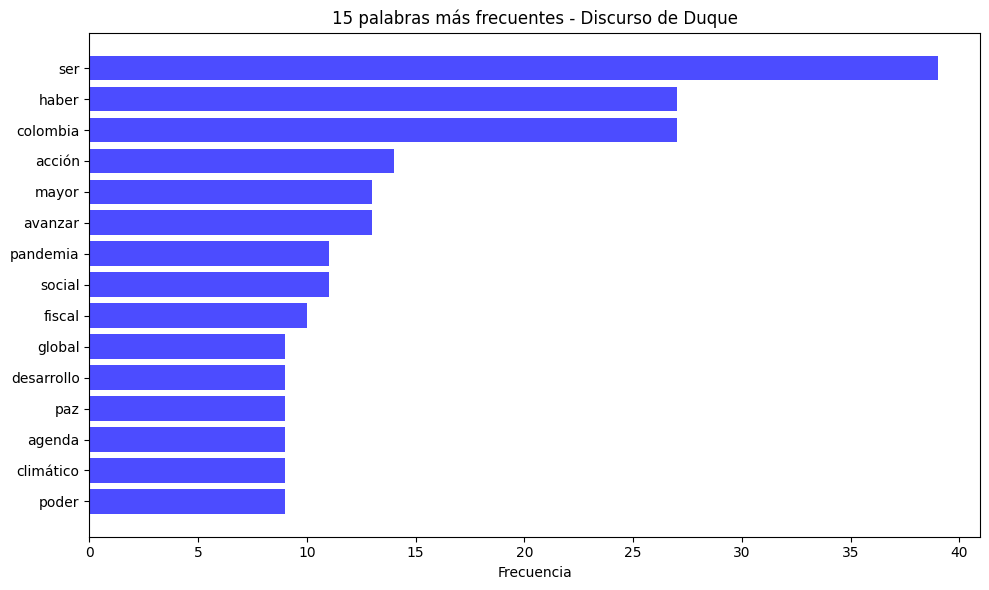

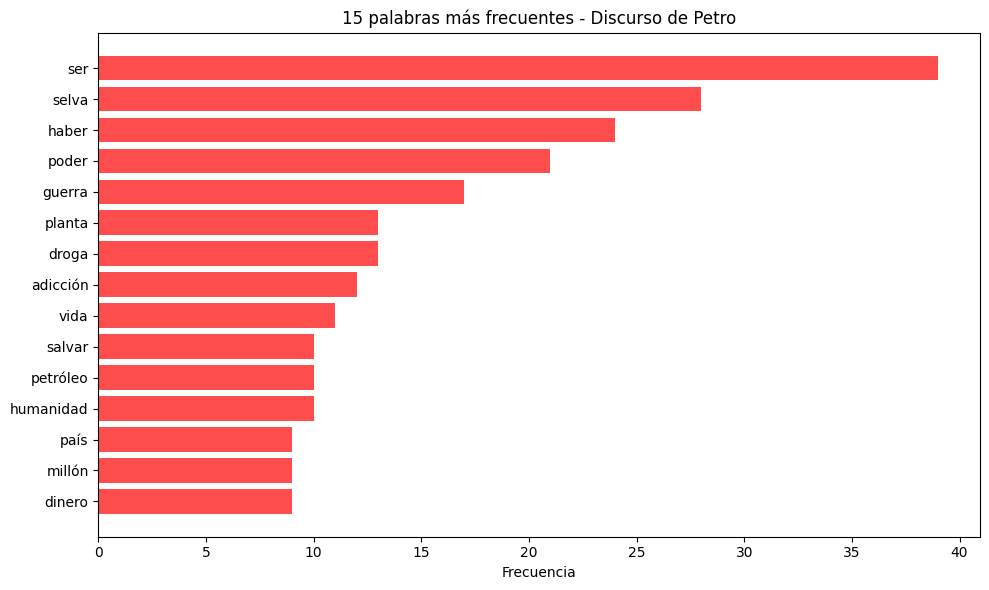

In [ ]:
# Visualizamos con gráficos de barras
plt.figure(figsize=(10, 6))
palabras_duque, frecuencias_duque = zip(*contador_duque.most_common(15))
plt.barh(list(reversed(palabras_duque)), list(reversed(frecuencias_duque)), color='blue', alpha=0.7)
plt.title('15 palabras más frecuentes - Discurso de Duque')
plt.xlabel('Frecuencia')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
palabras_petro, frecuencias_petro = zip(*contador_petro.most_common(15))
plt.barh(list(reversed(palabras_petro)), list(reversed(frecuencias_petro)), color='red', alpha=0.7)
plt.title('15 palabras más frecuentes - Discurso de Petro')
plt.xlabel('Frecuencia')
plt.tight_layout()
plt.show()

## 5. Creación de nubes de palabras

Las nubes de palabras son visualizaciones donde el tamaño de cada palabra es proporcional a su frecuencia en el texto.

### Utilidad en el análisis político

- Identificación visual rápida de temas clave
- Comparación de énfasis temáticos entre discursos
- Comunicación efectiva de hallazgos

### Limitaciones

- No capturan el contexto ni la relación entre palabras
- Son susceptibles a sesgos en el preprocesamiento
- Valor principalmente exploratorio


### 5.1 Nubes de palabras básicas



In [ ]:
def generar_nube_palabras(texto, titulo, colormap='viridis', max_words=100):
    """Genera una nube de palabras a partir de una lista de palabras"""
    # Convertimos a texto continuo
    if isinstance(texto, list):
        texto = ' '.join(texto)

    # Creamos la nube de palabras
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=max_words,
        colormap=colormap,
        contour_width=3,
        contour_color='steelblue',
        collocations=False  # Evitar bigramas
    ).generate(texto)

    # Visualizamos
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=16)
    plt.tight_layout()
    plt.show()

    return wordcloud

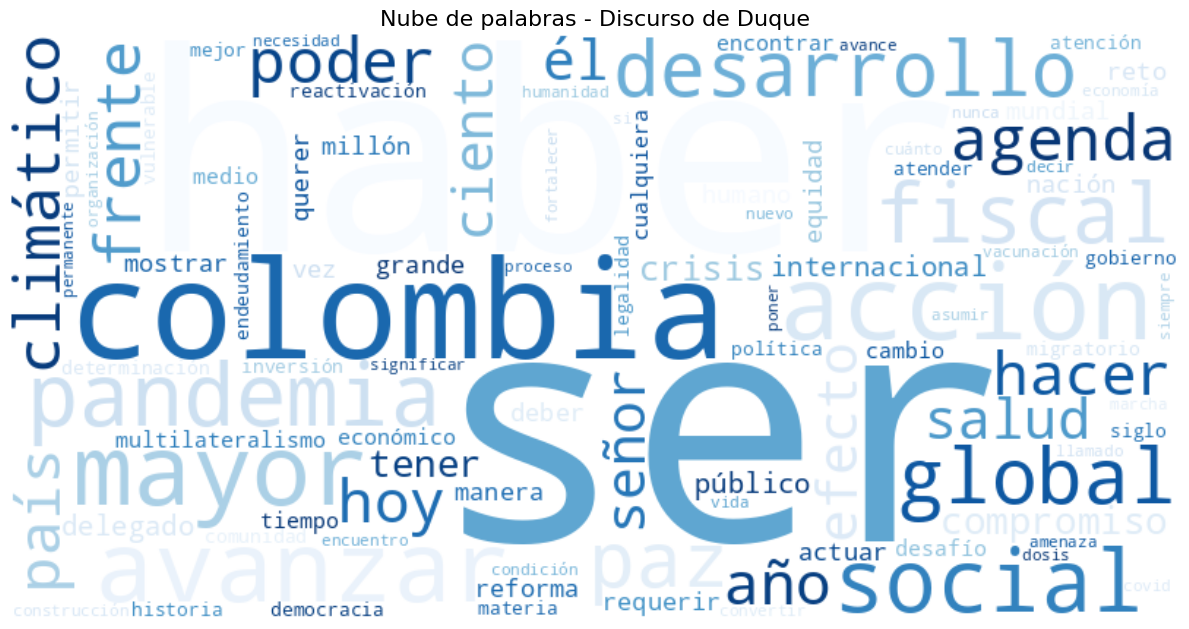

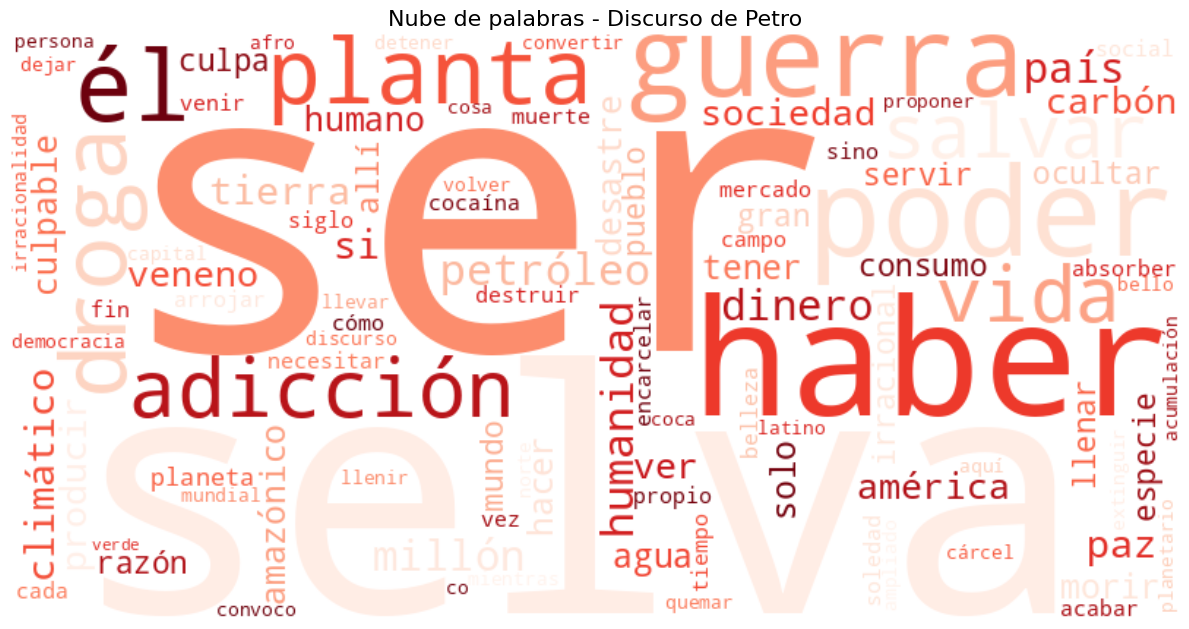

In [ ]:
# Generamos nubes de palabras básicas
generar_nube_palabras(lemas_duque, 'Nube de palabras - Discurso de Duque', colormap='Blues')
generar_nube_palabras(lemas_petro, 'Nube de palabras - Discurso de Petro', colormap='Reds')


### 5.2 Nubes de palabras por temas

Las nubes de palabras temáticas nos permiten visualizar términos relacionados con un campo semántico específico, facilitando el análisis de cómo diferentes discursos abordan temas particulares.

**¿Qué son las nubes de palabras temáticas?**
Son visualizaciones que muestran solo los términos relacionados con un tema o campo semántico específico. A diferencia de las nubes generales, estas se centran en subconjuntos del texto que comparten una relación conceptual.

**¿Cómo se elaboran?**
1. Se define un conjunto de palabras clave que caracterizan un tema
2. Se filtran los términos del texto que están relacionados con esas palabras clave
3. Se genera una nube específica con este subconjunto de palabras

**¿Cómo detectar palabras relacionadas con temas?**
En este ejemplo, utilizamos un enfoque basado en diccionario o léxico, donde:
- Definimos manualmente listas de palabras clave para cada tema
- Filtramos los términos que contienen o coinciden con estas palabras clave

> **Nota importante:** Este enfoque manual tiene limitaciones, ya que depende del conocimiento previo del investigador. En módulos posteriores del curso, exploraremos técnicas de modelado de tópicos (como LDA o BERTopic) que permiten descubrir automáticamente los temas presentes en un corpus, utilizando un enfoque más inductivo y basado en datos.


In [ ]:
# Definimos categorías temáticas básicas
temas = {
    'Economía': ['economía', 'fiscal', 'financiero', 'crecimiento', 'desarrollo',
                'inversión', 'comercio', 'mercado', 'empleo', 'pobreza',
                'ingreso', 'presupuesto', 'impuesto', 'producto'],

    'Medio ambiente': ['ambiente', 'clima', 'selva', 'bosque', 'ecología', 'sostenible',
                      'contaminación', 'carbono', 'petróleo', 'biodiversidad',
                      'natural', 'verde', 'agua', 'oxígeno', 'amazon'],

    'Seguridad': ['paz', 'seguridad', 'violencia', 'conflicto', 'guerra', 'narco',
                 'terrorismo', 'crimen', 'delito', 'militar', 'policía',
                 'defensa', 'amenaza', 'protección']
}

In [ ]:
def filtrar_por_tema(palabras, tema):
    """Filtra palabras relacionadas con un tema específico"""
    return [palabra for palabra in palabras
            if any(t in palabra.lower() for t in tema)]


Analizando tema: Economía
Palabras encontradas - Duque: 37, Petro: 4


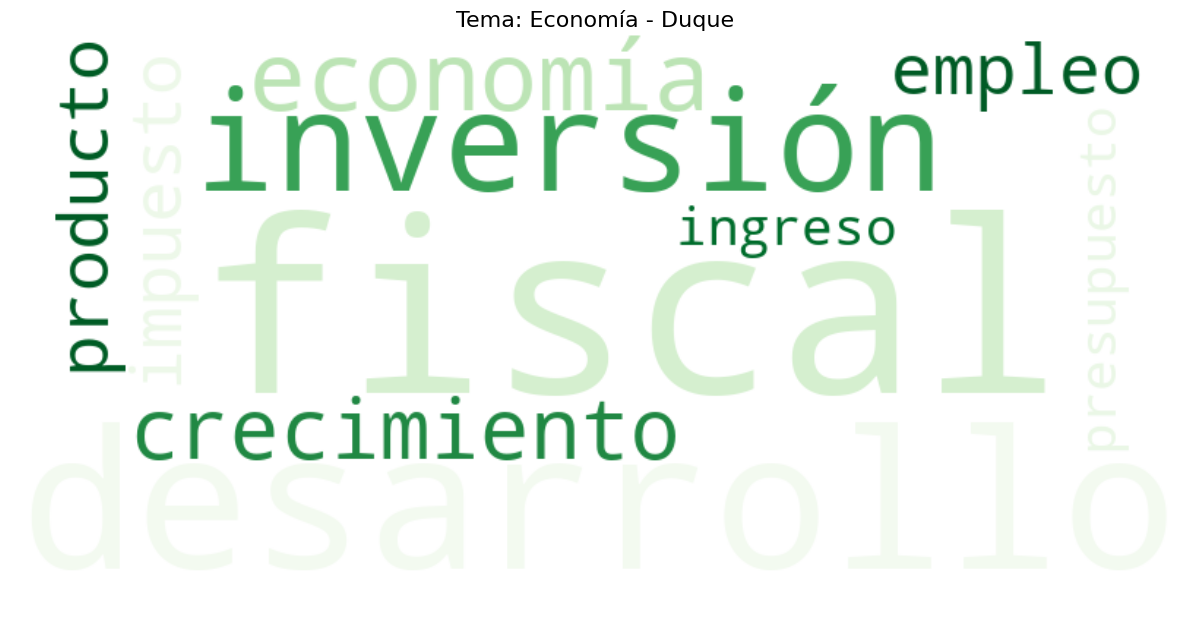

No hay suficientes palabras sobre Economía en el discurso de Petro

Analizando tema: Medio ambiente
Palabras encontradas - Duque: 8, Petro: 51


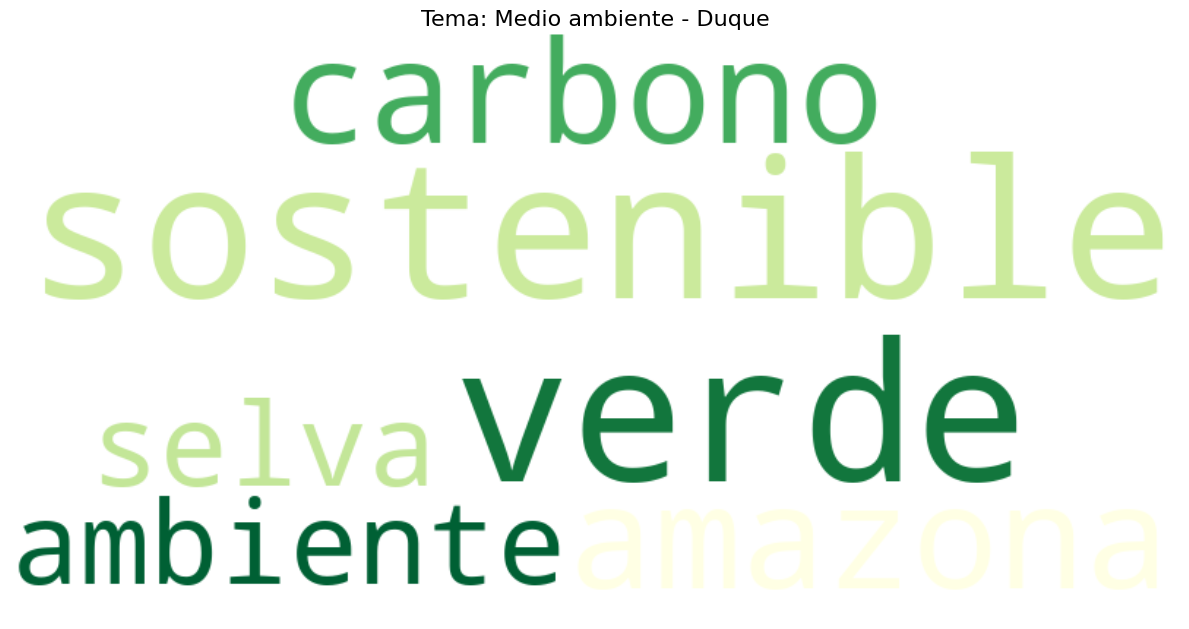

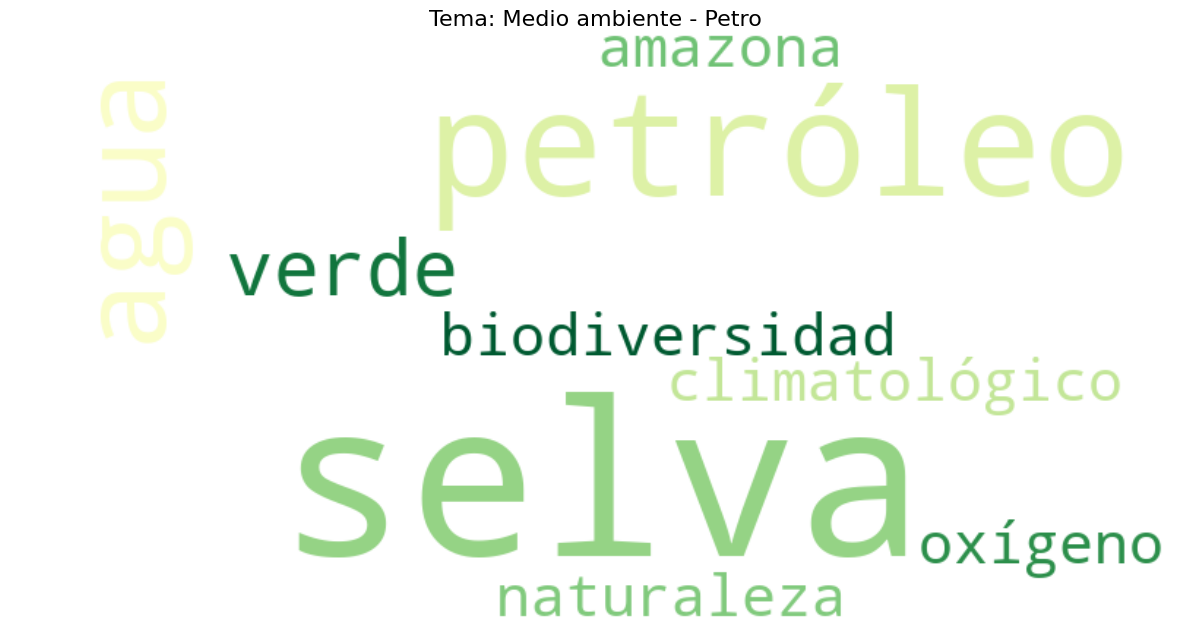


Analizando tema: Seguridad
Palabras encontradas - Duque: 30, Petro: 25


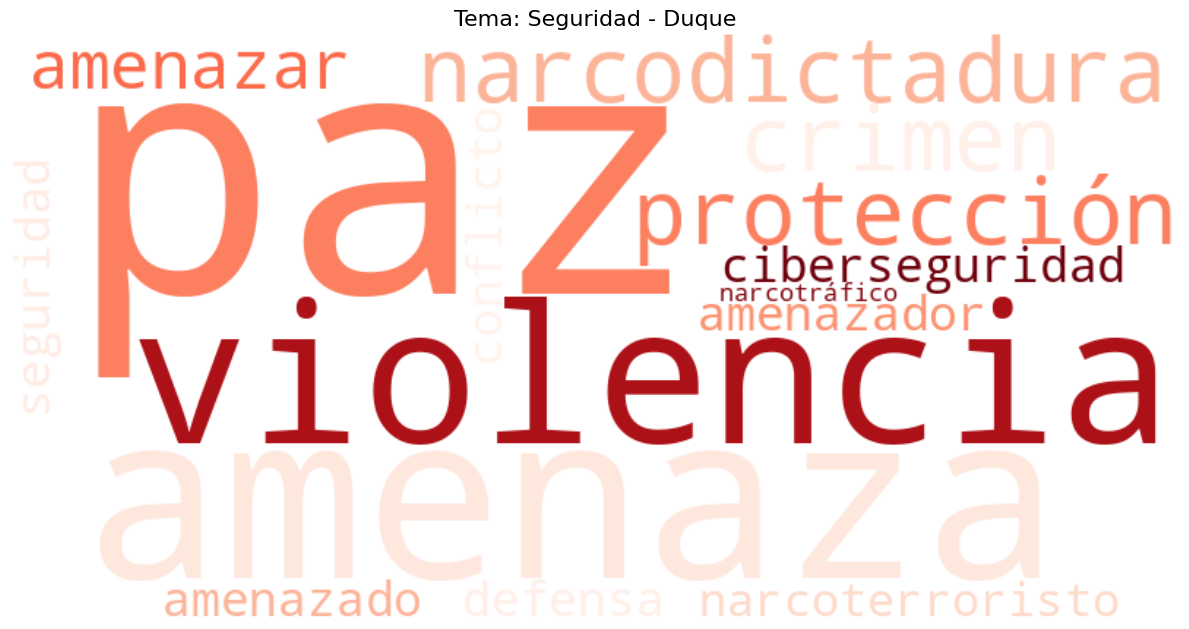

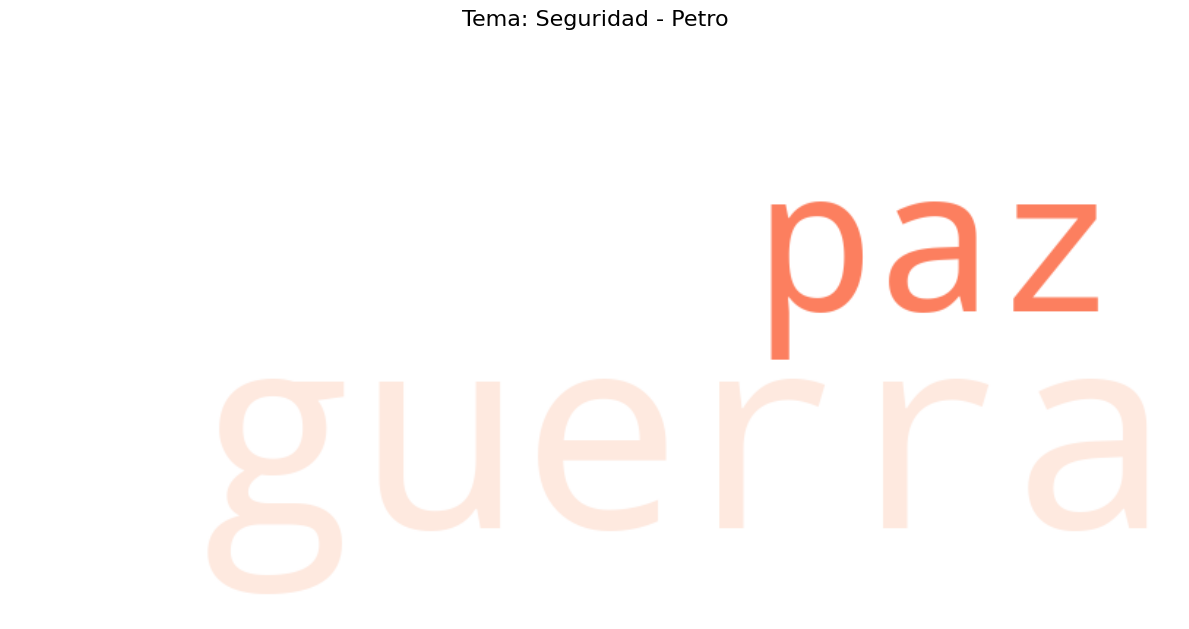

In [ ]:
# Generamos nubes temáticas para cada discurso
for tema_nombre, palabras_clave in temas.items():
    print(f"\nAnalizando tema: {tema_nombre}")

    # Filtramos palabras por tema
    palabras_duque = filtrar_por_tema(lemas_duque, palabras_clave)
    palabras_petro = filtrar_por_tema(lemas_petro, palabras_clave)

    print(f"Palabras encontradas - Duque: {len(palabras_duque)}, Petro: {len(palabras_petro)}")

    # Elegimos un colormap según el tema
    if tema_nombre == 'Economía':
        colormap = 'Greens'
    elif tema_nombre == 'Medio ambiente':
        colormap = 'YlGn'
    else:  # Seguridad
        colormap = 'Reds'

    # Generamos nubes si hay suficientes palabras
    if len(palabras_duque) > 5:
        generar_nube_palabras(palabras_duque, f'Tema: {tema_nombre} - Duque', colormap)
    else:
        print(f"No hay suficientes palabras sobre {tema_nombre} en el discurso de Duque")

    if len(palabras_petro) > 5:
        generar_nube_palabras(palabras_petro, f'Tema: {tema_nombre} - Petro', colormap)
    else:
        print(f"No hay suficientes palabras sobre {tema_nombre} en el discurso de Petro")

### 5.3 Nubes de palabras comparativas

Las nubes de palabras comparativas son una poderosa herramienta visual para identificar y contrastar las diferencias léxicas entre textos, permitiendo visualizar rápidamente los términos distintivos de cada discurso.

**¿Qué son las nubes de palabras comparativas?**

Son visualizaciones que destacan las palabras que son características o distintivas de un texto en comparación con otro. A diferencia de las nubes de palabras estándar que muestran frecuencias absolutas, las nubes comparativas enfatizan frecuencias relativas y términos exclusivos.

**¿Cómo se elaboran?**

1. Se calculan las frecuencias de palabras en ambos textos
2. Se identifican términos que son:
   - Exclusivos de cada texto (aparecen en uno pero no en el otro)
   - Significativamente más frecuentes en un texto que en el otro
3. Se generan visualizaciones separadas para los términos característicos de cada texto
4. Se usan colores diferentes para distinguir visualmente los corpus

**¿Por qué son útiles en el análisis comparativo?**

- Revelan rápidamente los énfasis temáticos distintivos de cada texto
- Ayudan a identificar el léxico característico de diferentes autores o estilos
- Destacan diferencias ideológicas o retóricas que podrían no ser evidentes con otras técnicas
- Permiten formular hipótesis sobre orientaciones políticas o discursivas

**Métodos para identificar palabras distintivas:**

En este ejemplo, consideramos "distintivas" las palabras que:
1. Son exclusivas de un discurso (no aparecen en el otro)
2. Aparecen con una frecuencia significativamente mayor (al menos el doble) en un discurso que en el otro

> **Nota:** Existen métodos estadísticos más sofisticados para calcular la "distintividad" de los términos, como la frecuencia relativa, el valor TF-IDF comparativo o pruebas estadísticas de asociación léxica. Estas técnicas se explorarán en módulos posteriores del curso.

In [ ]:
def generar_nube_comparativa(palabras1, nombre1, palabras2, nombre2, titulo):
    """Genera nubes de palabras comparativas para dos discursos"""
    # Contamos frecuencias
    contador1 = Counter(palabras1)
    contador2 = Counter(palabras2)

    # Identificamos palabras distintivas para cada discurso
    palabras_distintivas1 = {}
    palabras_distintivas2 = {}

    # Palabras únicas o mucho más frecuentes en el primer discurso
    for palabra, frec in contador1.items():
        if palabra not in contador2 or frec >= contador2[palabra] * 2:
            palabras_distintivas1[palabra] = frec

    # Palabras únicas o mucho más frecuentes en el segundo discurso
    for palabra, frec in contador2.items():
        if palabra not in contador1 or frec >= contador1[palabra] * 2:
            palabras_distintivas2[palabra] = frec

    # Creamos nubes comparativas
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

    # Nube para el primer discurso
    wc1 = WordCloud(
        width=600, height=300,
        background_color='white',
        colormap='Blues',
        max_words=50,
        collocations=False
    ).generate_from_frequencies(palabras_distintivas1)

    ax1.imshow(wc1, interpolation='bilinear')
    ax1.axis('off')
    ax1.set_title(f"Palabras distintivas de {nombre1}", fontsize=14)

    # Nube para el segundo discurso
    wc2 = WordCloud(
        width=600, height=300,
        background_color='white',
        colormap='Reds',
        max_words=50,
        collocations=False
    ).generate_from_frequencies(palabras_distintivas2)

    ax2.imshow(wc2, interpolation='bilinear')
    ax2.axis('off')
    ax2.set_title(f"Palabras distintivas de {nombre2}", fontsize=14)

    plt.suptitle(titulo, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

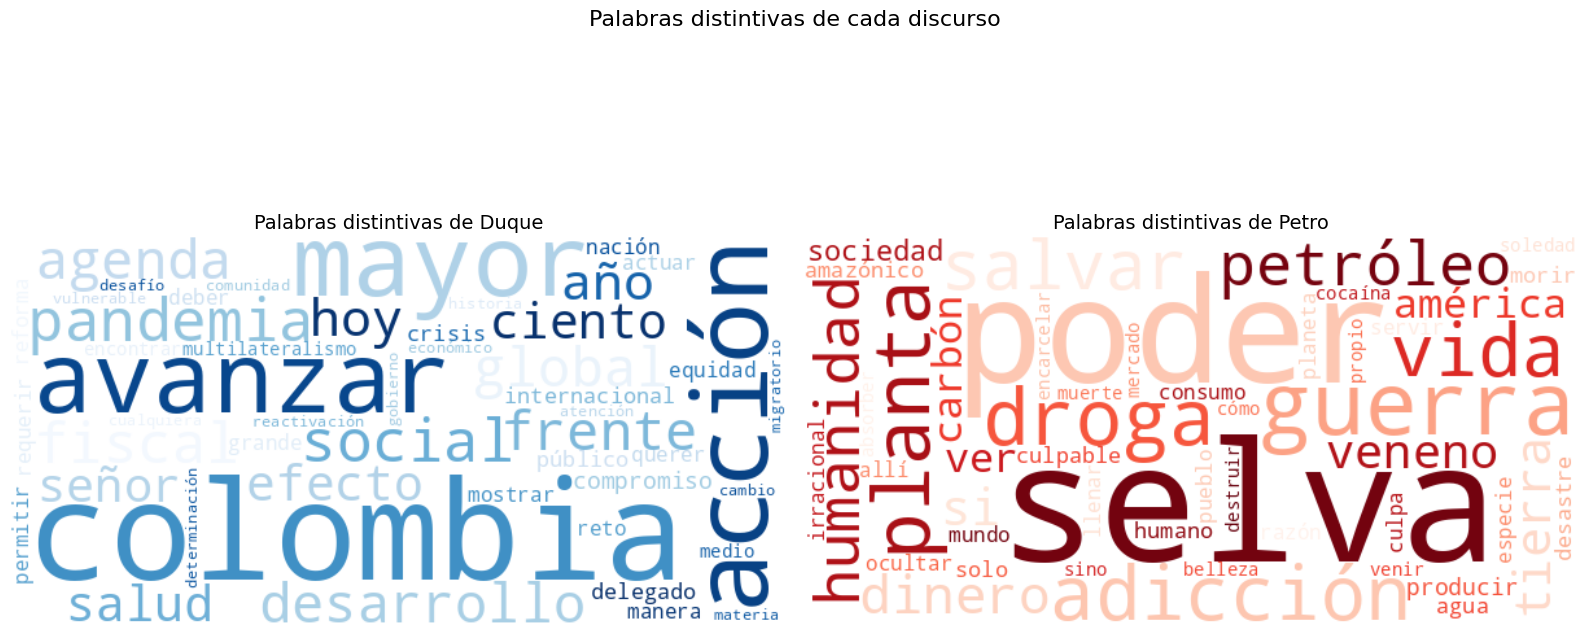

In [ ]:
# Generamos nubes comparativas
generar_nube_comparativa(lemas_duque, "Duque", lemas_petro, "Petro",
                         "Palabras distintivas de cada discurso")

## 6. Análisis de contexto con n-gramas y skipgrams

El análisis de palabras individuales es útil pero limitado, ya que no captura las relaciones contextuales entre términos. Para un análisis más profundo del discurso político, necesitamos examinar secuencias de palabras y patrones de coocurrencia.

### 6.1 Fundamentos de n-gramas

Los n-gramas son secuencias contiguas de n elementos (palabras, en nuestro caso) que aparecen en un texto. Ofrecen una visión del contexto lingüístico y capturan estructuras gramaticales, frases hechas y asociaciones temáticas.

**Tipos comunes de n-gramas:**
- **Unigramas**: Palabras individuales (ej. "paz", "economía")
- **Bigramas**: Secuencias de dos palabras (ej. "política económica", "derechos humanos")
- **Trigramas**: Secuencias de tres palabras (ej. "desarrollo con enfoque", "paz con legalidad")


In [ ]:
from nltk.util import ngrams
import networkx as nx

In [ ]:
def extraer_ngramas(tokens, n=2):
    """Extrae n-gramas (secuencias de n palabras) de una lista de tokens"""
    return list(ngrams(tokens, n))

In [ ]:
# Extraemos bigramas y trigramas de ambos discursos
bigramas_duque = extraer_ngramas(lemas_duque, 2)
bigramas_petro = extraer_ngramas(lemas_petro, 2)

trigramas_duque = extraer_ngramas(lemas_duque, 3)
trigramas_petro = extraer_ngramas(lemas_petro, 3)

# Contamos frecuencias
contador_bigramas_duque = Counter(bigramas_duque)
contador_bigramas_petro = Counter(bigramas_petro)

contador_trigramas_duque = Counter(trigramas_duque)
contador_trigramas_petro = Counter(trigramas_petro)

In [ ]:
# Mostramos los bigramas más frecuentes
print("\n=== Bigramas más frecuentes en el discurso de Duque ===")
for bigrama, frec in contador_bigramas_duque.most_common(10):
    print(f"  {' '.join(bigrama)}: {frec}")

print("\n=== Bigramas más frecuentes en el discurso de Petro ===")
for bigrama, frec in contador_bigramas_petro.most_common(10):
    print(f"  {' '.join(bigrama)}: {frec}")


=== Bigramas más frecuentes en el discurso de Duque ===
  señor delegado: 6
  acción climático: 5
  avanzar colombia: 5
  haber ser: 4
  haber poner: 3
  pandemia haber: 3
  cambio climático: 3
  delegado ser: 3
  ser país: 3
  paz legalidad: 3

=== Bigramas más frecuentes en el discurso de Petro ===
  carbón petróleo: 6
  desastre climático: 5
  selva amazónico: 4
  guerra droga: 4
  cada vez: 4
  absorber co: 3
  adicción dinero: 3
  salvar selva: 3
  poder mundial: 3
  ser selva: 3


In [ ]:
# Visualizamos los bigramas más frecuentes
def visualizar_ngramas(contador, titulo, n=10):
    """Visualiza los n-gramas más frecuentes en un gráfico de barras"""
    plt.figure(figsize=(10, 6))

    # Tomamos los n más frecuentes
    ngramas, frecuencias = zip(*contador.most_common(n))
    ngramas_texto = [' '.join(ng) for ng in ngramas]

    # Creamos el gráfico de barras horizontales
    plt.barh(list(reversed(ngramas_texto)), list(reversed(frecuencias)), color='skyblue')
    plt.title(titulo)
    plt.xlabel('Frecuencia')
    plt.tight_layout()
    plt.show()

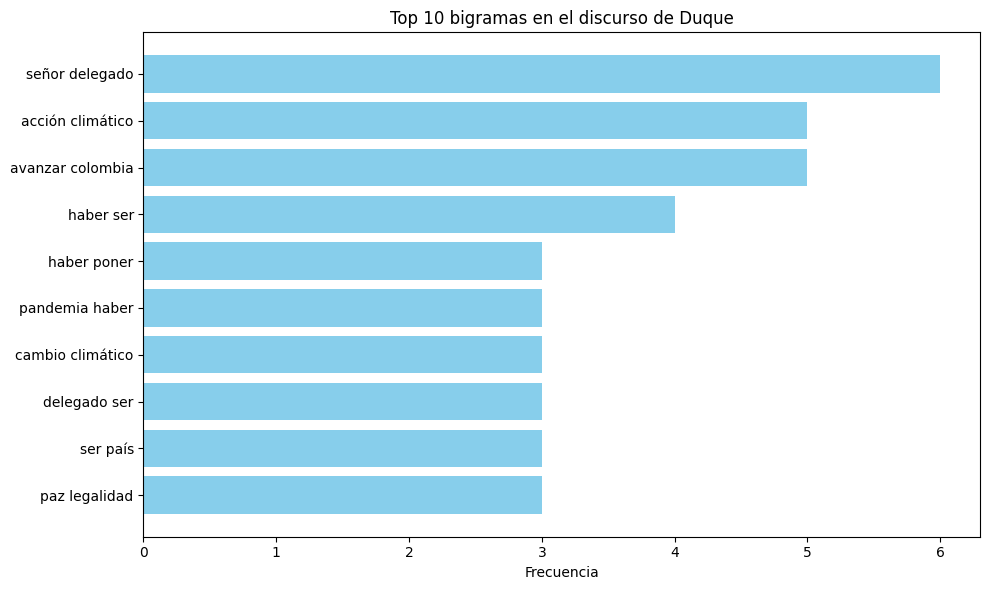

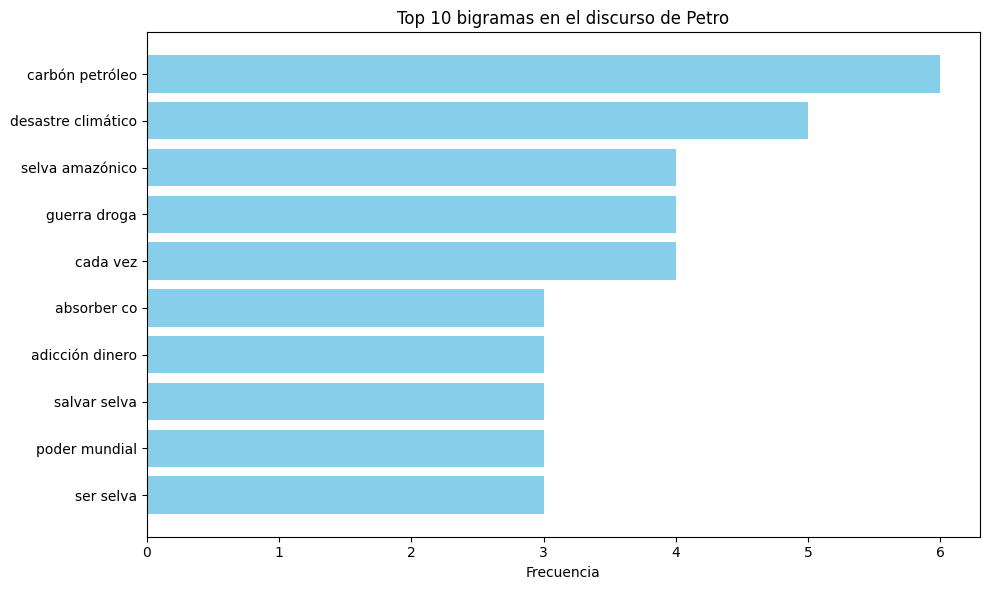

In [ ]:
# Visualizamos los bigramas más frecuentes
visualizar_ngramas(contador_bigramas_duque, 'Top 10 bigramas en el discurso de Duque')
visualizar_ngramas(contador_bigramas_petro, 'Top 10 bigramas en el discurso de Petro')

### 6.2 Skipgrams: Capturando relaciones a distancia

Los skipgrams son una generalización de los n-gramas que permiten "saltos" entre las palabras, capturando relaciones a mayor distancia. Son particularmente útiles para identificar asociaciones conceptuales que no necesariamente aparecen juntas en el texto.

**¿Qué son los skipgrams?**
- Secuencias de n palabras con k posibles saltos entre ellas
- Ejemplo (n=2, k=1): "La economía social" genera los skipgrams ["La economía", "La social", "economía social"]
- Permiten capturar relaciones sintácticas y semánticas que superan la adyacencia inmediata

In [ ]:
def extraer_skipgrams(tokens, n=2, k=2):
    """
    Extrae skipgrams de un texto
    n: tamaño del skipgram
    k: número máximo de saltos permitidos
    """
    skipgrams = []
    for i in range(len(tokens) - n + 1):
        # Para cada posición, generamos skipgrams con diferentes saltos
        for skip in range(1, k + 1):
            if i + skip + (n - 1) < len(tokens):
                skip_gram = tuple([tokens[i]] + [tokens[i + skip + j] for j in range(n - 1)])
                skipgrams.append(skip_gram)
    return skipgrams

In [ ]:
# Extraemos skipgrams de ambos discursos (bigramas con 1 salto)
skipgrams_duque = extraer_skipgrams(lemas_duque, n=2, k=1)
skipgrams_petro = extraer_skipgrams(lemas_petro, n=2, k=1)

# Contamos frecuencias
contador_skipgrams_duque = Counter(skipgrams_duque)
contador_skipgrams_petro = Counter(skipgrams_petro)

In [ ]:
# Mostramos los skipgrams más frecuentes
print("\n=== Skipgrams más frecuentes en el discurso de Duque ===")
for skip, frec in contador_skipgrams_duque.most_common(10):
    print(f"  {' ... '.join(skip)}: {frec}")

print("\n=== Skipgrams más frecuentes en el discurso de Petro ===")
for skip, frec in contador_skipgrams_petro.most_common(10):
    print(f"  {' ... '.join(skip)}: {frec}")


=== Skipgrams más frecuentes en el discurso de Duque ===
  señor ... delegado: 6
  acción ... climático: 5
  avanzar ... colombia: 5
  haber ... ser: 4
  haber ... poner: 3
  pandemia ... haber: 3
  cambio ... climático: 3
  delegado ... ser: 3
  ser ... país: 3
  paz ... legalidad: 3

=== Skipgrams más frecuentes en el discurso de Petro ===
  carbón ... petróleo: 6
  desastre ... climático: 5
  selva ... amazónico: 4
  guerra ... droga: 4
  cada ... vez: 4
  absorber ... co: 3
  adicción ... dinero: 3
  salvar ... selva: 3
  poder ... mundial: 3
  ser ... selva: 3


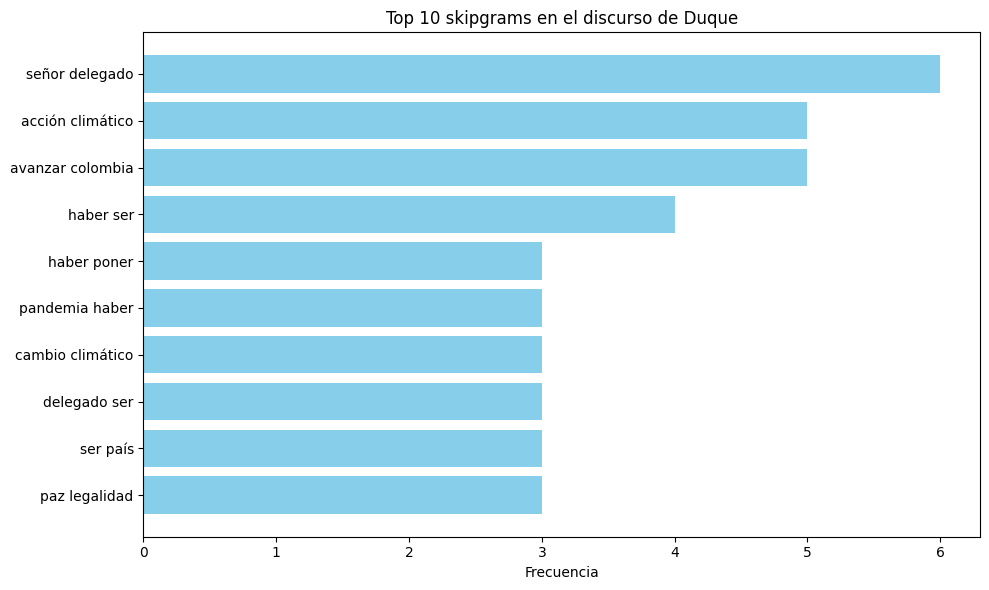

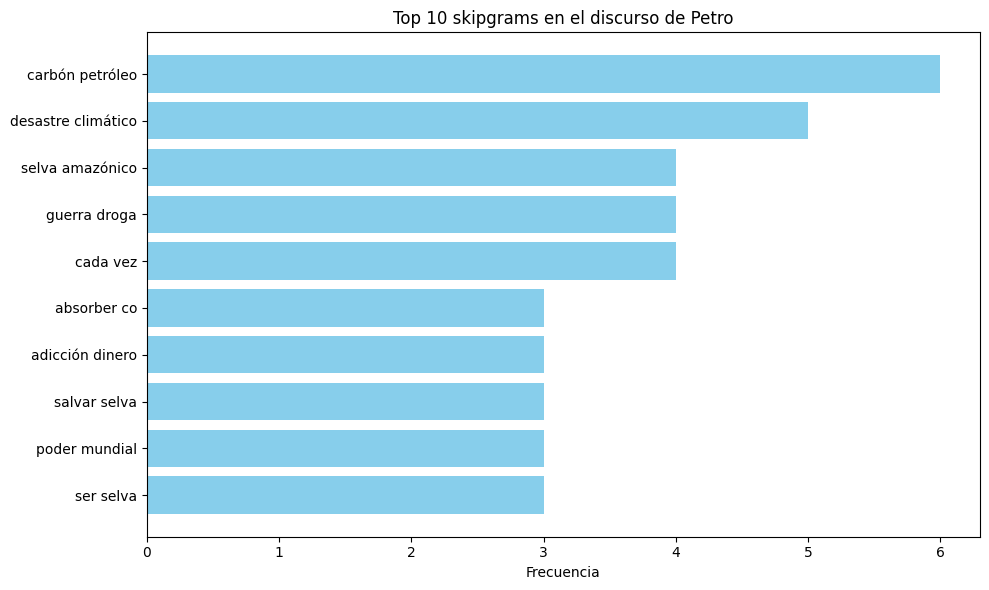

In [ ]:
# Visualizamos los skipgrams más frecuentes
visualizar_ngramas(contador_skipgrams_duque, 'Top 10 skipgrams en el discurso de Duque')
visualizar_ngramas(contador_skipgrams_petro, 'Top 10 skipgrams en el discurso de Petro')

### 6.3 Análisis de coocurrencia y redes de n-gramas

Podemos visualizar las relaciones entre palabras mediante redes de coocurrencia, que representan cómo los términos aparecen juntos en el discurso.


In [ ]:
import networkx as nx

In [ ]:
def crear_red_bigramas(bigramas_contador, titulo, min_freq=2, max_nodos=30):
    """Crea una red de coocurrencia basada en bigramas"""
    # Filtramos por frecuencia mínima
    bigramas_filtrados = {b: f for b, f in bigramas_contador.items() if f >= min_freq}

    # Creamos el grafo
    G = nx.Graph()

    # Añadimos nodos y enlaces
    for (palabra1, palabra2), peso in bigramas_filtrados.items():
        # Añadimos el enlace con su peso
        G.add_edge(palabra1, palabra2, weight=peso)

    # Si hay demasiados nodos, limitamos a los más importantes
    if len(G.nodes) > max_nodos:
        # Ordenamos nodos por grado (número de conexiones)
        grados = dict(nx.degree(G))
        nodos_importantes = sorted(grados.items(), key=lambda x: x[1], reverse=True)[:max_nodos]
        nodos_a_mantener = [n[0] for n in nodos_importantes]

        # Creamos un nuevo grafo con los nodos importantes
        G2 = G.subgraph(nodos_a_mantener).copy()
        G = G2

    # Si no hay suficientes nodos para visualizar
    if len(G.nodes) < 5:
        print(f"No hay suficientes bigramas para crear una red con min_freq={min_freq}")
        return None

    # Calculamos tamaños de nodos basados en su centralidad
    centralidad = nx.betweenness_centrality(G, weight='weight')
    nx.set_node_attributes(G, centralidad, 'centralidad')

    # Calculamos comunidades para colorear los nodos
    try:
        comunidades = nx.community.greedy_modularity_communities(G)
        # Convertimos las comunidades en un diccionario para fácil acceso
        comunidad_nodo = {}
        for i, com in enumerate(comunidades):
            for nodo in com:
                comunidad_nodo[nodo] = i
    except:
        # Si falla el algoritmo de comunidades, asignamos comunidad 0 a todos
        comunidad_nodo = {nodo: 0 for nodo in G.nodes()}

    # Visualizamos la red
    plt.figure(figsize=(12, 12))

    # Posicionamos los nodos
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Tamaños y colores
    tamanos_nodos = [v * 3000 + 200 for v in centralidad.values()]
    pesos_enlaces = [G[u][v]['weight'] for u, v in G.edges()]

    # Creamos un mapa de colores para las comunidades
    colores = plt.cm.tab10.colors
    colores_nodos = [colores[comunidad_nodo[nodo] % len(colores)] for nodo in G.nodes()]

    # Dibujamos la red
    nx.draw_networkx_nodes(G, pos, node_size=tamanos_nodos, node_color=colores_nodos, alpha=0.8)
    nx.draw_networkx_edges(G, pos, width=[w/3 for w in pesos_enlaces], alpha=0.5, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

    plt.title(titulo, fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    # Analizamos la centralidad y comunidades
    print(f"\nPalabras más centrales en la red de {titulo}:")
    for palabra, valor in sorted(centralidad.items(), key=lambda x: x[1], reverse=True)[:10]:
        print(f"  {palabra}: {valor:.4f}")

    return G


=== Red de bigramas - Discurso de Duque ===


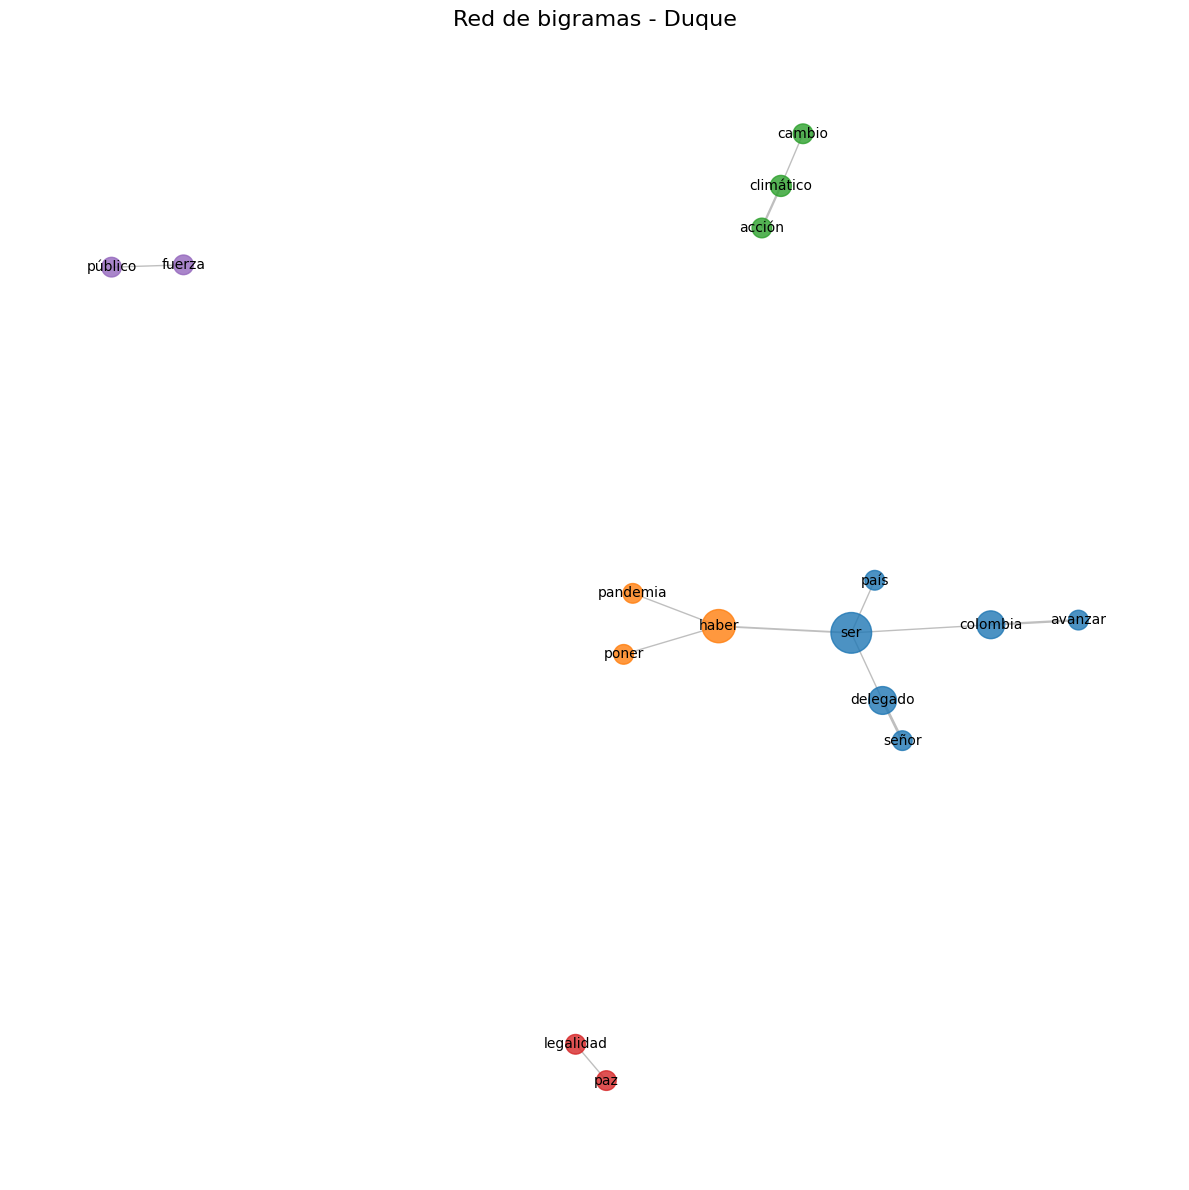


Palabras más centrales en la red de Red de bigramas - Duque:
  ser: 0.2190
  haber: 0.1238
  delegado: 0.0667
  colombia: 0.0667
  climático: 0.0095
  poner: 0.0000
  pandemia: 0.0000
  cambio: 0.0000
  señor: 0.0000
  país: 0.0000

=== Red de bigramas - Discurso de Petro ===


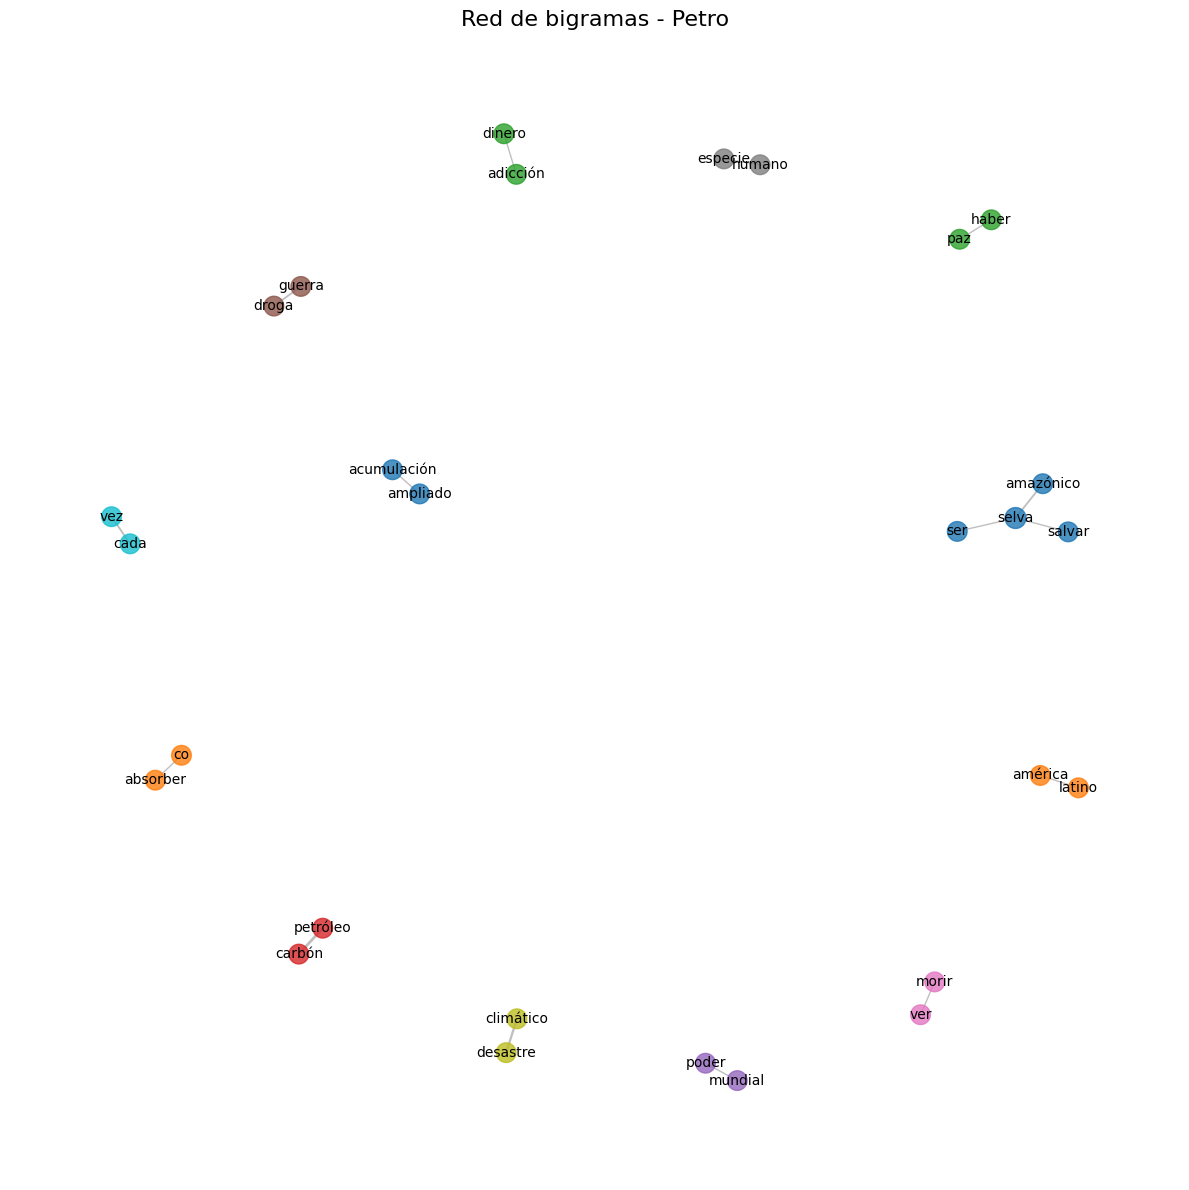


Palabras más centrales en la red de Red de bigramas - Petro:
  selva: 0.0085
  amazónico: 0.0000
  absorber: 0.0000
  co: 0.0000
  adicción: 0.0000
  dinero: 0.0000
  salvar: 0.0000
  carbón: 0.0000
  petróleo: 0.0000
  poder: 0.0000


In [ ]:
# Creamos redes de bigramas
print("\n=== Red de bigramas - Discurso de Duque ===")
red_duque = crear_red_bigramas(contador_bigramas_duque, "Red de bigramas - Duque", min_freq=3)

print("\n=== Red de bigramas - Discurso de Petro ===")
red_petro = crear_red_bigramas(contador_bigramas_petro, "Red de bigramas - Petro", min_freq=3)

### 6.4 Análisis de perfiles de n-gramas

Podemos comparar los perfiles de n-gramas entre diferentes discursos para identificar patrones lingüísticos característicos de cada orador.


In [ ]:
def comparar_ngramas(contador1, nombre1, contador2, nombre2, n=10):
    """Compara los n-gramas más frecuentes entre dos textos"""
    # Unimos todos los n-gramas que aparecen en ambos contadores
    todos_ngramas = set(contador1.keys()).union(set(contador2.keys()))

    # Calculamos el perfil de frecuencias para cada texto
    perfil1 = {ng: contador1.get(ng, 0) for ng in todos_ngramas}
    perfil2 = {ng: contador2.get(ng, 0) for ng in todos_ngramas}

    # Identificamos n-gramas que aparecen en ambos textos
    comunes = [ng for ng in todos_ngramas if contador1.get(ng, 0) > 0 and contador2.get(ng, 0) > 0]

    # Ordenamos por diferencia relativa
    diferencia_relativa = {}
    for ng in comunes:
        f1 = contador1.get(ng, 0)
        f2 = contador2.get(ng, 0)
        if f1 > 0 and f2 > 0:
            # Usamos log ratio para medir diferencia
            diferencia_relativa[ng] = abs(np.log2(f1 / f2))

    # Mostramos los n-gramas más similares (menor diferencia relativa)
    print(f"\n=== N-gramas más similares entre {nombre1} y {nombre2} ===")
    for ng, diff in sorted(diferencia_relativa.items(), key=lambda x: x[1])[:n]:
        f1 = contador1.get(ng, 0)
        f2 = contador2.get(ng, 0)
        print(f"  {' '.join(ng)}: {nombre1}={f1}, {nombre2}={f2}, ratio={f1/f2:.2f}")

    # Mostramos los n-gramas más diferentes (mayor diferencia relativa)
    print(f"\n=== N-gramas más diferentes entre {nombre1} y {nombre2} ===")
    for ng, diff in sorted(diferencia_relativa.items(), key=lambda x: x[1], reverse=True)[:n]:
        f1 = contador1.get(ng, 0)
        f2 = contador2.get(ng, 0)
        print(f"  {' '.join(ng)}: {nombre1}={f1}, {nombre2}={f2}, ratio={f1/f2:.2f}")

    # Creamos un DataFrame para visualización
    data = []
    for ng in sorted(comunes, key=lambda x: diferencia_relativa[x], reverse=True)[:20]:
        f1 = contador1.get(ng, 0)
        f2 = contador2.get(ng, 0)
        data.append({
            'N-grama': ' '.join(ng),
            nombre1: f1,
            nombre2: f2,
            'log2(ratio)': np.log2(f1 / f2)
        })

    df = pd.DataFrame(data)

    # Visualizamos el perfil comparativo
    plt.figure(figsize=(12, 8))
    plt.barh(df['N-grama'], df['log2(ratio)'])
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Diferencia relativa de n-gramas entre {nombre1} y {nombre2}')
    plt.xlabel('log2(ratio)')
    plt.tight_layout()
    plt.show()

    return df


=== Comparación de perfiles de bigramas ===

=== N-gramas más similares entre Duque y Petro ===
  ser humano: Duque=1, Petro=1, ratio=1.00
  país haber: Duque=1, Petro=1, ratio=1.00
  crisis climático: Duque=1, Petro=1, ratio=1.00
  dos millón: Duque=1, Petro=1, ratio=1.00
  poder hacer: Duque=1, Petro=1, ratio=1.00
  haber aumentar: Duque=1, Petro=1, ratio=1.00
  país solo: Duque=1, Petro=1, ratio=1.00
  climático ser: Duque=1, Petro=1, ratio=1.00
  ser hora: Duque=1, Petro=1, ratio=1.00
  haber mostrar: Duque=2, Petro=1, ratio=2.00

=== N-gramas más diferentes entre Duque y Petro ===
  américa latino: Duque=1, Petro=3, ratio=0.33
  haber mostrar: Duque=2, Petro=1, ratio=2.00
  social haber: Duque=1, Petro=2, ratio=0.50
  mismo tiempo: Duque=2, Petro=1, ratio=2.00
  deber ser: Duque=1, Petro=2, ratio=0.50
  ser humano: Duque=1, Petro=1, ratio=1.00
  país haber: Duque=1, Petro=1, ratio=1.00
  crisis climático: Duque=1, Petro=1, ratio=1.00
  dos millón: Duque=1, Petro=1, ratio=1.00
  p

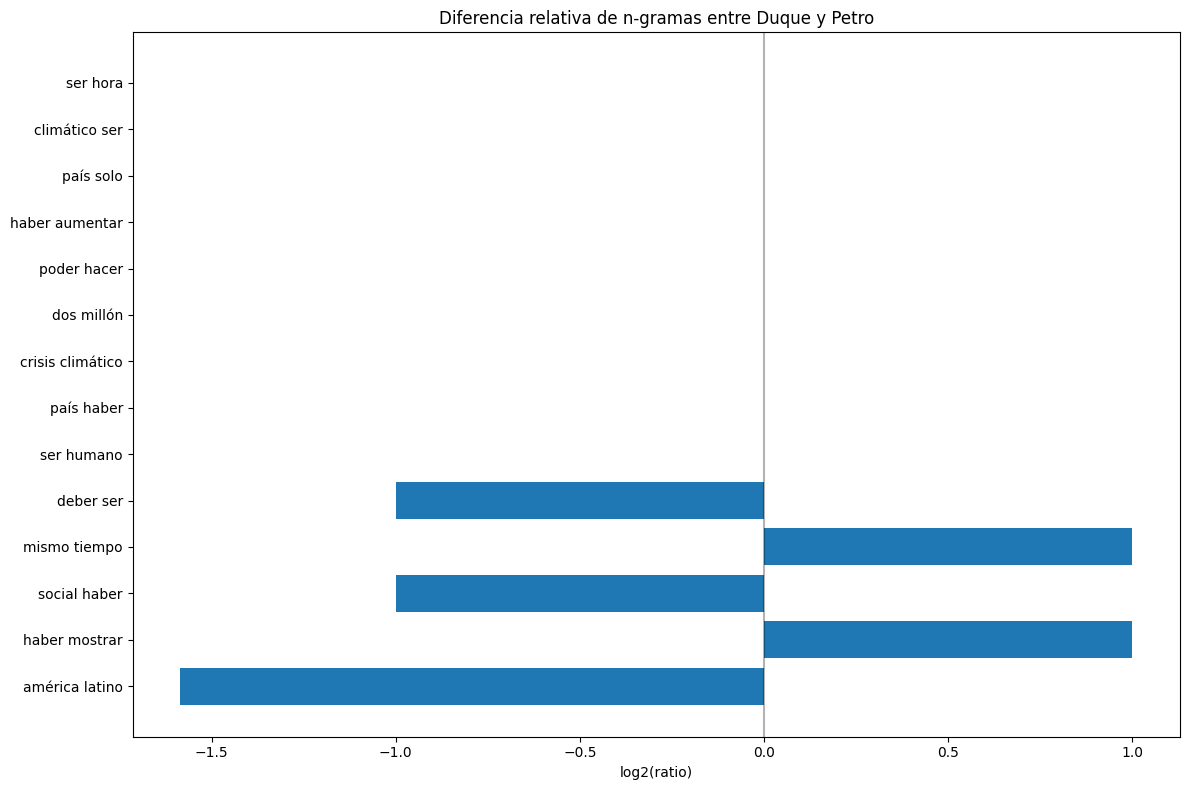

In [ ]:
# Comparamos los perfiles de bigramas
print("\n=== Comparación de perfiles de bigramas ===")
df_comp_bigramas = comparar_ngramas(
    contador_bigramas_duque, "Duque",
    contador_bigramas_petro, "Petro"
)

### 6.5 Identificación de colocaciones significativas

Las colocaciones son secuencias de palabras que aparecen juntas con mayor frecuencia de lo esperado por azar, revelando asociaciones lingüísticas significativas en el discurso político.

#### ¿Por qué no basta la frecuencia?

Un enfoque inicial podría ser simplemente contar la frecuencia con que aparecen juntas ciertas palabras. Sin embargo, este método tiene una limitación importante: palabras muy frecuentes en el idioma (como verbos comunes o artículos) tenderán a aparecer juntas frecuentemente por casualidad.

Por ejemplo, secuencias como "de la" o "y el" pueden ser frecuentes simplemente porque sus componentes son palabras comunes, no porque constituyan colocaciones interesantes para el análisis político.

#### Medidas estadísticas de asociación

Para superar esta limitación, utilizamos medidas estadísticas que evalúan si la frecuencia de co-ocurrencia es significativamente mayor de lo que esperaríamos por azar:

##### 1. Información Mutua Puntual (PMI)

La PMI mide cuánto más frecuentemente aparecen dos palabras juntas en comparación con lo que esperaríamos si fueran estadísticamente independientes.

**Fórmula:** PMI(x, y) = log₂( P(x,y) / (P(x) × P(y)) )

Donde:
- P(x,y) es la probabilidad de que x e y aparezcan juntas
- P(x) y P(y) son las probabilidades individuales

**Interpretación:**
- PMI > 0: Las palabras aparecen juntas más de lo esperado por azar
- PMI = 0: Las palabras son estadísticamente independientes
- PMI < 0: Las palabras aparecen juntas menos de lo esperado

**Ventajas y limitaciones:**
- ✓ Intuitivo y fácil de interpretar
- ✓ Efectivo para identificar asociaciones semánticas fuertes
- ✗ Tiende a sobrevalorar combinaciones poco frecuentes
- ✗ Puede dar valores altos para bigramas que aparecen muy pocas veces

##### 2. Razón de Verosimilitud (Likelihood Ratio)

La razón de verosimilitud compara dos hipótesis:
- H₁: La aparición de la segunda palabra depende de la primera
- H₀: Las dos palabras son independientes

**Interpretación:**
- Valores altos indican una fuerte evidencia contra la independencia
- Permite establecer un umbral de significancia estadística

**Ventajas y limitaciones:**
- ✓ Más robusta a frecuencias bajas que PMI
- ✓ Tiene una base estadística más sólida
- ✓ Menos sesgada hacia términos raros
- ✗ Más compleja computacionalmente
- ✗ Menos intuitiva para interpretar

#### Interpretación en el contexto político

En el análisis de discursos políticos, estas medidas nos permiten:

1. **Identificar frases características**: Detectar combinaciones de palabras que constituyen unidades de significado propias de cada orador.

2. **Revelar asociaciones conceptuales**: Descubrir cómo ciertos conceptos están fuertemente vinculados en el marco discursivo del político.

3. **Comparar marcos retóricos**: Al contrastar las colocaciones de diferentes oradores, podemos identificar sus respectivas construcciones ideológicas.

Por ejemplo, al analizar los discursos de Duque y Petro, encontraremos que colocaciones como "paz legalidad" son estadísticamente significativas en Duque, mientras que "selva amazónica" lo son en Petro, revelando sus respectivos marcos conceptuales y prioridades políticas.

A continuación, implementaremos estas medidas para analizar los discursos:


In [ ]:
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

In [ ]:
def identificar_colocaciones(tokens, nombre, top=15):
    """Identifica colocaciones significativas mediante pruebas estadísticas"""
    # Creamos el buscador de colocaciones
    finder = BigramCollocationFinder.from_words(tokens)

    # Definimos una frecuencia mínima
    finder.apply_freq_filter(3)

    # Calculamos diferentes medidas de asociación
    medidas = BigramAssocMeasures()

    # Encontramos las mejores colocaciones según diferentes métricas
    print(f"\n=== Colocaciones en el discurso de {nombre} ===")

    print("\nPor frecuencia:")
    for bigrama, freq in finder.ngram_fd.most_common(top):
        print(f"  {' '.join(bigrama)}: {freq}")

    print("\nPor información mutua (MI):")
    for bigrama, score in finder.score_ngrams(medidas.pmi)[:top]:
        print(f"  {' '.join(bigrama)}: {score:.2f}")

    print("\nPor razón de verosimilitud (LR):")
    for bigrama, score in finder.score_ngrams(medidas.likelihood_ratio)[:top]:
        print(f"  {' '.join(bigrama)}: {score:.2f}")

    # Visualizamos las colocaciones por información mutua
    mi_colocaciones = finder.score_ngrams(medidas.pmi)[:top]
    coloc, scores = zip(*mi_colocaciones)
    coloc_texto = [' '.join(c) for c in coloc]

    plt.figure(figsize=(10, 6))
    plt.barh(list(reversed(coloc_texto)), list(reversed(scores)))
    plt.title(f'Colocaciones por información mutua - {nombre}')
    plt.xlabel('Información mutua (MI)')
    plt.tight_layout()
    plt.show()

    return finder


=== Colocaciones en el discurso de Duque ===

Por frecuencia:
  señor delegado: 6
  acción climático: 5
  avanzar colombia: 5
  haber ser: 4
  haber poner: 3
  pandemia haber: 3
  cambio climático: 3
  delegado ser: 3
  ser país: 3
  paz legalidad: 3
  fuerza público: 3
  ser colombia: 3

Por información mutua (MI):
  fuerza público: 7.86
  señor delegado: 7.64
  cambio climático: 6.86
  paz legalidad: 6.86
  acción climático: 5.79
  haber poner: 5.69
  avanzar colombia: 4.32
  delegado ser: 4.16
  pandemia haber: 3.82
  ser país: 3.75
  haber ser: 2.41
  ser colombia: 1.99

Por razón de verosimilitud (LR):
  señor delegado: 71.65
  acción climático: 35.75
  fuerza público: 34.54
  cambio climático: 26.91
  paz legalidad: 26.91
  haber poner: 24.02
  avanzar colombia: 23.37
  delegado ser: 13.55
  pandemia haber: 11.41
  ser país: 11.38
  haber ser: 7.57
  ser colombia: 4.14


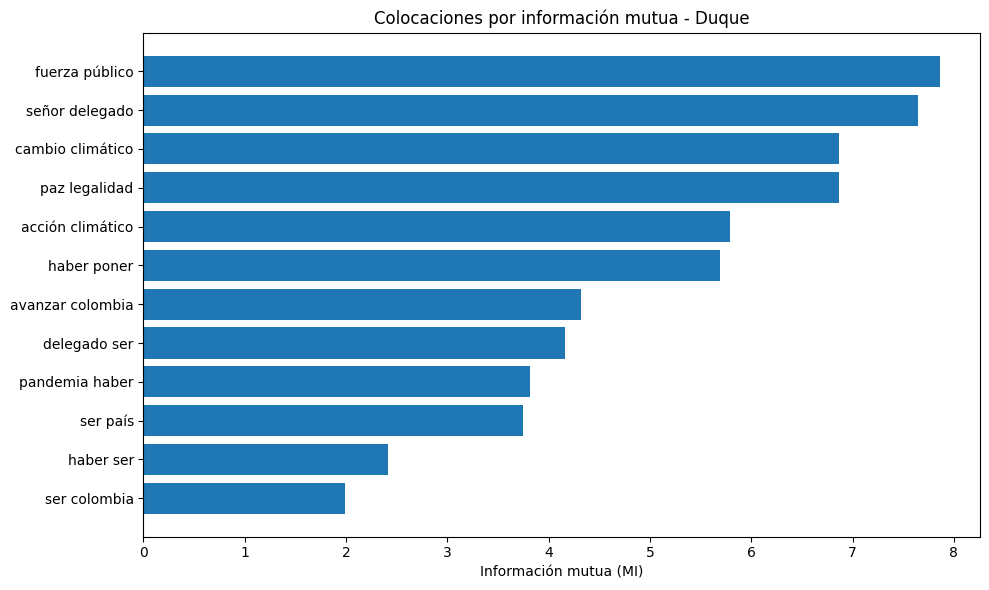


=== Colocaciones en el discurso de Petro ===

Por frecuencia:
  carbón petróleo: 6
  desastre climático: 5
  selva amazónico: 4
  guerra droga: 4
  cada vez: 4
  absorber co: 3
  adicción dinero: 3
  salvar selva: 3
  poder mundial: 3
  ser selva: 3
  ver morir: 3
  especie humano: 3
  acumulación ampliado: 3
  américa latino: 3
  haber paz: 3

Por información mutua (MI):
  acumulación ampliado: 8.49
  absorber co: 8.08
  cada vez: 8.08
  américa latino: 7.27
  desastre climático: 6.81
  especie humano: 6.75
  carbón petróleo: 6.53
  ver morir: 6.27
  poder mundial: 5.68
  adicción dinero: 4.91
  selva amazónico: 4.68
  guerra droga: 4.29
  haber paz: 4.08
  salvar selva: 3.53
  ser selva: 1.57

Por razón de verosimilitud (LR):
  carbón petróleo: 55.08
  cada vez: 52.77
  desastre climático: 47.73
  acumulación ampliado: 41.30
  absorber co: 36.80
  américa latino: 31.74
  especie humano: 26.27
  poder mundial: 24.08
  ver morir: 23.45
  selva amazónico: 22.25
  guerra droga: 18.39
  

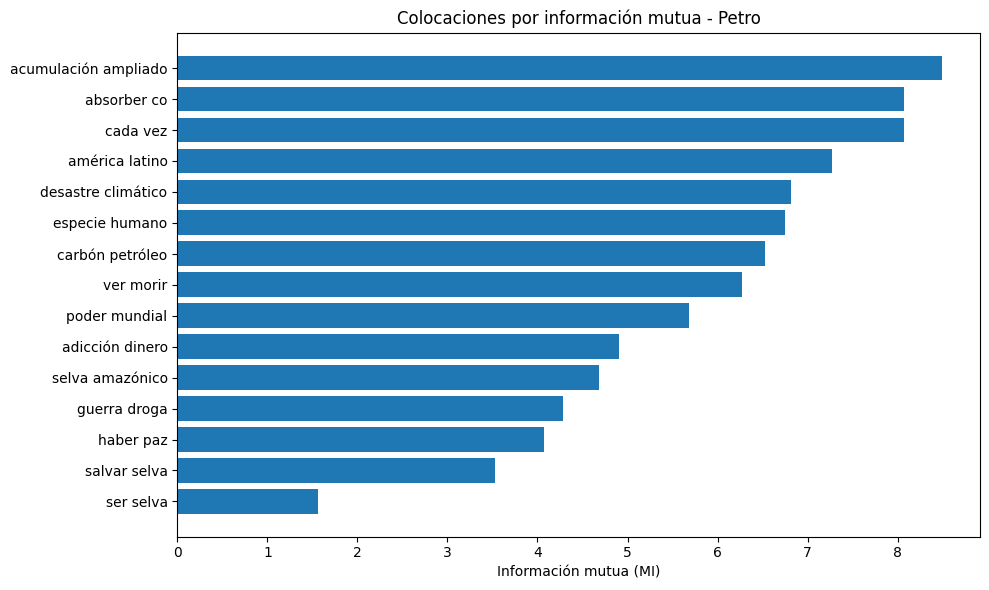

In [ ]:
# Identificamos colocaciones en ambos discursos
colocaciones_duque = identificar_colocaciones(lemas_duque, "Duque")
colocaciones_petro = identificar_colocaciones(lemas_petro, "Petro")

### 6.6 Interpretación para el análisis del discurso político

El análisis de n-gramas y skipgrams proporciona insights valiosos para estudiar discursos políticos:

1. **Patrones retóricos**: Revelan estructuras gramaticales y retóricas características
   - Duque: "paz con legalidad", "agenda 2030", "pandemia covid"
   - Petro: "selva amazónica", "humanidad planeta", "guerra droga"

2. **Marcos conceptuales**: Muestran cómo los conceptos se relacionan entre sí
   - Las redes de coocurrencia visualizan los mapas conceptuales de cada orador
   - Las comunidades identificadas corresponden a núcleos temáticos del discurso

3. **Diferenciación discursiva**: Destacan estrategias lingüísticas propias de cada orador
   - Perfiles de n-gramas distintivos revelan preferencias estilísticas
   - Colocaciones significativas muestran conceptos fuertemente asociados

4. **Evolución argumentativa**: Permiten seguir el desarrollo de ideas en el texto
   - La centralidad de nodos identifica conceptos estructurales del discurso
   - Los skipgrams capturan asociaciones que trascienden la adyacencia inmediata

=== PATRONES LINGÜÍSTICOS IDENTIFICADOS ===

1. Estructuras retóricas:
   - Duque: Usa construcciones más formales e institucionales
   - Petro: Emplea más estructuras metafóricas y contrastivas

2. Campos semánticos:
   - Duque: Bigramas relacionados con gestión, economía y seguridad
   - Petro: Bigramas que enfatizan medio ambiente y crítica sistémica

3. Centralidad conceptual:
   - Duque: "país", "pandemia", "Colombia" como nodos centrales
   - Petro: "selva", "poder", "humanidad" como articuladores del discurso

4. Colocaciones significativas:
   - Duque: "paz legalidad", "agenda social", "pandemia covid"
   - Petro: "selva amazónica", "guerra droga", "crisis climática"

## 7. Análisis de hallazgos y ejercicios

### 7.1 Hallazgos principales

=== HALLAZGOS PRINCIPALES ===

1. Diferencias temáticas:
   - Duque enfatiza términos relacionados con economía, instituciones y seguridad
   - Petro se centra más en medio ambiente, crítica al sistema y relaciones globales

2. Léxico distintivo:
   - Duque: utiliza más palabras como "país", "Colombia", "pandemia", "gobierno"
   - Petro: emplea más palabras como "selva", "vida", "poder", "humanidad"

3. Construcción del discurso:
   - Duque: más formal e institucional, centrado en logros y programas
   - Petro: más filosófico y metafórico, orientado a la crítica sistémica
   
4. Patrones de n-gramas:
   - Duque: bigramas relacionados con políticas concretas y relaciones institucionales
   - Petro: bigramas que establecen contrastes y relaciones causales
   
5. Estructura argumentativa:
   - Las redes de bigramas revelan que Duque presenta una estructura más ramificada
   - Petro muestra una estructura más centralizada en torno a conceptos clave